In [31]:
import numpy as np
import pandas as pd
import pickle

from sklearn.cluster import KMeans

from tqdm import tqdm

In [41]:
def kmeans(df, 
           cols = ['latitude', 'longitude'], 
           n_cluster = 12):
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(df[cols])
    return kmeans


class MultiBayesACT:
    def __init__(self, data, geo_clusters, act_clusters):
        self.data = data #should be a dataframe
        self.geo_clusters = geo_clusters
        self.act_clusters = act_clusters
        print('Model loaded!')

    def admit_rate(self, name):
        if name not in self.data.college_name.unique():
            print(f'College {name} was not found')
            return -1
        return self.data[self.data.college_name == name].admit_rate.values[0]


    def pTOKENS_H(self, df, college_name, tokens):
        college = df[df.college_name == college_name]
        n_players = len(college)

        pTOKENS_H = 1
        for token, value in tokens.items():
            n_token = len(college[college[token] == value])
            pTokenI_H = n_token / n_players
            pTOKENS_H *= pTokenI_H

        return pTOKENS_H


    def pTOKENS_notH(self, df, college_name, tokens):
        not_college = df[df.college_name != college_name]
        n_players_not_college = len(not_college)

        pTOKENS_notH = 1
        for token, value in tokens.items():
            n_not_token = len(not_college[not_college[token] == value])
            pTokenI_notH = n_not_token / n_players_not_college
            pTOKENS_notH *= pTokenI_notH

        return pTOKENS_notH


    def multiple_bayes(self, df, college_name, tokens):
        admissions_rate = self.admit_rate(college_name)
        pT_H = self.pTOKENS_H(df, college_name, tokens)
        pT_notH = self.pTOKENS_notH(df, college_name, tokens)
        numerator = admissions_rate * pT_H
        denominator_right_half = (1 - admissions_rate) * pT_notH
        denominator_full = numerator + denominator_right_half
        pH_T = numerator / denominator_full

        return pH_T, admissions_rate

    def predict(self, college_name, tokens, relative=False):
        df = self.data.copy()
        pred, admit_rate = self.multiple_bayes(df, college_name, tokens)
        if pred > 0:
            if relative:
                pred /= self.admit_rate(college_name)
            return pred, admit_rate
        else:
            return np.nan, admit_rate

In [42]:
X = pd.read_csv('X.csv')
y = np.load('y.npy')

with open('label_encoder.pickle', 'rb') as f:
    le = pickle.load(f)

X['college_name'] = le.inverse_transform(y)
geo_clusters = kmeans(X, 
                      cols = ['latitude', 'longitude'], 
                      n_cluster = 12)
X['geo_cluster'] = geo_clusters.labels_

#Figuring out optimal cluster:
#plt.plot([kmeans(X, cols = ['actmed'], n_cluster = i).inertia_ for i in tqdm(range(3, 36))])
act_clusters = kmeans(X, cols = ['actmed'], n_cluster = 5)
X['act_cluster'] = act_clusters.labels_

rates = pd.read_csv('../name_matches.csv')

cols = ['act_cluster', 'geo_cluster', 'Position_Defender',
        'Position_Forward', 'Position_Goalkeeper', 'Position_Midfielder',
        'Class_Freshman', 'Class_Junior', 'Class_Redshirt Freshman',
        'Class_Senior', 'Class_Sophomore', 'college_name',
        'admit_rate']

data = X.merge(rates, how='left', left_on='college_name', right_on='d_names').dropna()[cols]

/Users/mgb/anaconda3/envs/flask/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [43]:
mb = MultiBayesACT(data, geo_clusters, act_clusters)

Model loaded!


In [44]:
name = 'Alabama-Huntsville'
mb.admit_rate(name)

0.8062317429406037

ACT: 28


{'act_cluster': 0, 'geo_cluster': 10}


In [57]:
act_score = input('ACT:')

tokens = {
    'act_cluster': mb.act_clusters.predict([[act_score]])[0],
    'geo_cluster': 10,
}

res = []
for name in tqdm(mb.data.college_name.unique()):
    res.append([name, mb.predict(name, tokens, relative=True)[0]])
    
preds = pd.DataFrame.from_records(res, columns = ['college_name', 'relative_likelihood'])

ACT: 18


100%|██████████| 359/359 [00:02<00:00, 178.39it/s]


In [58]:
preds.dropna()

,college_name,relative_likelihood
59,Barry,2.021305
61,St. Edward's,1.350263
74,Lees-McRae College,1.880548
75,Truett-McConnell College,1.856027
76,Young Harris College,1.814706
79,Georgia Southwestern,1.454054
150,Curry,1.151577
212,Barton,2.300741
215,Chowan,1.573740
218,Greensboro College,1.265752


In [49]:
preds.dropna()

,college_name,relative_likelihood
3,Montevallo,1.129770
4,Spring Hill,1.573427
6,Central Arkansas,1.003351
7,Harding,1.154746
26,Redlands,1.021893
27,San Diego State,1.124960
42,Regis,1.020083
58,Howard,1.827742
60,Eckerd,1.359794
62,Florida Atlantic,1.920040


In [50]:
mb.act_clusters.cluster_centers_

array([[28.81399632],
       [21.54194572],
       [33.45309568],
       [18.17318794],
       [24.91077371]])

<AxesSubplot:ylabel='Frequency'>

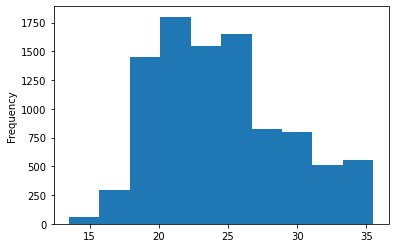

In [51]:
X.actmed.plot(kind='hist')